### Import Libraries

In [128]:
import pandas as pd              # Pandas Library
import matplotlib.pyplot as plt  # Plotting Library
import numpy as np               # Numpy Library
import tensorflow as tf          # Tensorflow Library
from tslearn.clustering import TimeSeriesKMeans # Clustering

### Autoencoder Data

In [2]:
df = pd.read_csv('Gearbox Dataset/Run_1.csv', header=None) # Read Dataframe
df.head() # Look at the data

,0,1,2
0,0.012054,0.003204,4.9133
1,0.010071,0.005188,4.9097
2,0.014954,0.004883,4.9158
3,0.014496,0.005798,4.9158
4,0.018005,0.003815,4.9243


#### Note:
    
    1. Columns 0 and 1 are vibration data and Column 2 is Tachometer Signal

In [3]:
print('Shape of dataframe:', df.shape) # Shape of Dataframe

Shape of dataframe: (133328, 3)


#### Plot data

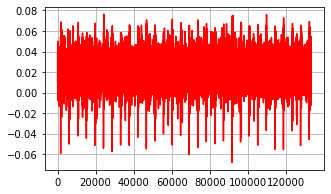

In [4]:
plt.figure(figsize=(5,3)) # Figure
plt.plot(df[0], color='red') # Plot
plt.grid(True) # Grid
plt.show() # Show

#### Prepare Data to feed into Autoencoder

In [9]:
# Normalize
x = np.array(df[[0]][0:51000]) # Dataframe as numpy array
x = ((x-np.max(x))+(x-np.min(x)))/(np.max(x)-np.min(x)) # Normalize ==> [-1,1]
print('Max: ', np.max(x)) # Print
print('Min:', np.min(x)) # Print

Max:  1.0
Min: -1.0


#### Prepare Train Test Split

In [16]:
train_length = int(x.shape[0]*0.75) # Length of train set
train, test = x[0:train_length], x[train_length:] # Train Test Data
print('Train Shape:', train.shape) # Print shape
print('Test Shape:', test.shape) # Print shape

Train Shape: (38250, 1)
Test Shape: (12750, 1)


### Important Note:

       1. The data which we feed into auto encoder should be a 3 dimensional array.
       
       2. It should be the array of ===>> [n_samples-n_sequences, n_sequences, 1]
       
       3. Example: If our time series is ===>> [1,2,3,4,5,6,7,8,9] 
                   n_samples = 9
                   n_sequence = 3 (Assume)       
          We should make our time series as:
                   Feature ===> Labels
                   [1,2,3] ===> [4]
                   [2,3,4] ===> [5]
                   [3,4,5] ===> [6]
                   [4,5,6] ===> [7]
                   [5,6,7] ===> [8]
                   [6,7,8] ===> [9]   
       4. In reality the sequences will be as given below:
          [ [[1],[2],[3]], 
            [[2],[3],[4]], 
            [[3],[4],[5]],
            [[4],[5],[6]], 
            [[5],[6],[7]],
            [[6],[7],[8]]] ]   Shape ==> [6,3,1]

#### Helper Function to create Sequences

In [17]:
def to_sequence(x,y,seq_size=1): 
    '''Creates a Sequence array for Features and Labels'''
    x_vs = [] # Empty List
    y_vs = [] # Empty List
    for i in range(len(x)-seq_size):  # Loop
        x_vs.append(x[i:i+seq_size])  # Features
        y_vs.append(y[i+seq_size])    # Labels
    
    return np.array(x_vs), np.array(y_vs)

#### Create Sequences

In [18]:
seq_size = 8100      # Sequence Size
trainX, trainY = to_sequence(train, train, seq_size) # Prepare Train data to sequence
testX, testY = to_sequence(test, test, seq_size) # Prepare Test data to sequence

In [19]:
print('TrainX Shape:', trainX.shape) # Print Shape
print('TrainY Shape:', trainY.shape) # Print Shape

TrainX Shape: (30150, 8100, 1)
TrainY Shape: (30150, 1)


In [20]:
print('TestX Shape:', testX.shape) # Print Shape
print('TestY Shape:', testY.shape) # Print Shape

TestX Shape: (4650, 8100, 1)
TestY Shape: (4650, 1)


### Auto-Encoder Model 

        1. The Autoencoder is going to be defined with the help of Functional API.

In [21]:
INPUT_LAYER = tf.keras.layers.Input(shape=(trainX.shape[1], trainX.shape[2]), name='input_layer') # Input Layer
ENCODER_1 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', strides=3, activation='relu', name='Encoder_1')(INPUT_LAYER) # Encoder Layer 1
DROPOUT_1_1 = tf.keras.layers.Dropout(0.2, name='Dropout_1')(ENCODER_1) # Dropout Layer
ENCODER_2 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', strides=3, activation='relu', name='Encoder_2')(DROPOUT_1_1) # Encoder Layer 2
DROPOUT_1_2 = tf.keras.layers.Dropout(0.2, name='Dropout_2')(ENCODER_2) # Dropout Layer
ENCODER_3 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', strides=3, activation='relu', name='Encoder_3')(DROPOUT_1_2) # Encoder Layer 3
DROPOUT_1_3 = tf.keras.layers.Dropout(0.2, name='Dropout_3')(ENCODER_3) # Dropout Layer
ENCODER_4 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', strides=3, activation='relu', name='Encoder_4')(DROPOUT_1_3) # Encoder Layer 3
CODED = tf.keras.layers.Conv1D(filters=1, kernel_size=5, padding='same', name='Encryption')(ENCODER_4) # Encrypted Layer

DECODER_1 = tf.keras.layers.Conv1DTranspose(filters=16, kernel_size=5, padding='same', strides=3, activation='relu', name='Decoder_1')(ENCODER_4) # Decoder Layer 1
DROPOUT_2_1 = tf.keras.layers.Dropout(0.2, name='Dropout_4')(DECODER_1) # Dropout Layer
DECODER_2 = tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=5, padding='same', strides=3, activation='relu', name='Decoder_2')(DROPOUT_2_1) # Decoder Layer 2
DROPOUT_2_2 = tf.keras.layers.Dropout(0.2, name='Dropout_5')(DECODER_2) # Dropout Layer
DECODER_3 = tf.keras.layers.Conv1DTranspose(filters=64, kernel_size=5, padding='same', strides=3, activation='relu', name='Decoder_3')(DROPOUT_2_2) # Decoder Layer 3
DROPOUT_2_3 = tf.keras.layers.Dropout(0.2, name='Dropout_6')(DECODER_3) # Dropout Layer
DECODER_4 = tf.keras.layers.Conv1DTranspose(filters=128, kernel_size=5, padding='same', strides=3, activation='relu', name='Decoder_4')(DROPOUT_2_3) # Decoder Layer
RECONSTRUCT = tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=5, padding='same', name='Reconstructor')(DECODER_4) # Reconstructor Layer

#### Define Model for Encoder-Decoder

In [22]:
AUTOENCODER = tf.keras.Model(inputs=INPUT_LAYER, outputs=RECONSTRUCT, name='AUTOENCODER') # Define Model
AUTOENCODER.summary() # Summarize

Model: "AUTOENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8100, 1)]         0         
_________________________________________________________________
Encoder_1 (Conv1D)           (None, 2700, 128)         768       
_________________________________________________________________
Dropout_1 (Dropout)          (None, 2700, 128)         0         
_________________________________________________________________
Encoder_2 (Conv1D)           (None, 900, 64)           41024     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 900, 64)           0         
_________________________________________________________________
Encoder_3 (Conv1D)           (None, 300, 32)           10272     
_________________________________________________________________
Dropout_3 (Dropout)          (None, 300, 32)           

#### Define Model for Encoder

In [23]:
ENCODER = tf.keras.Model(inputs=INPUT_LAYER, outputs=CODED, name='ENCODER') # Encoder Model
ENCODER.summary() # Summarize

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8100, 1)]         0         
_________________________________________________________________
Encoder_1 (Conv1D)           (None, 2700, 128)         768       
_________________________________________________________________
Dropout_1 (Dropout)          (None, 2700, 128)         0         
_________________________________________________________________
Encoder_2 (Conv1D)           (None, 900, 64)           41024     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 900, 64)           0         
_________________________________________________________________
Encoder_3 (Conv1D)           (None, 300, 32)           10272     
_________________________________________________________________
Dropout_3 (Dropout)          (None, 300, 32)           0   

#### Compile Model

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # ADAM Optimizer
loss = tf.keras.losses.MeanSquaredError() # Loss
accuracy = tf.keras.metrics.MeanAbsoluteError() # Metrics
AUTOENCODER.compile(optimizer=optimizer, loss=loss, metrics=[accuracy]) # Compile

#### Epochs

In [25]:
epochs = 3 # Number of Epochs

#### Fit Model

In [27]:
history = AUTOENCODER.fit(trainX, trainX, batch_size=32, epochs=epochs, validation_split=0.2, shuffle=False, verbose=1) # Fit Model

Epoch 1/3
754/754 [==============================] - 674s 892ms/step - loss: 0.0124 - mean_absolute_error: 0.0822 - val_loss: 0.0081 - val_mean_absolute_error: 0.0688
Epoch 2/3
754/754 [==============================] - 675s 895ms/step - loss: 0.0070 - mean_absolute_error: 0.0636 - val_loss: 0.0074 - val_mean_absolute_error: 0.0674
Epoch 3/3
754/754 [==============================] - 675s 895ms/step - loss: 0.0056 - mean_absolute_error: 0.0562 - val_loss: 0.0076 - val_mean_absolute_error: 0.0715


#### Predict 

In [28]:
y_pred = AUTOENCODER.predict(testX, verbose=1) # Predict 

146/146 [==============================] - 41s 280ms/step


In [29]:
print('Shape of Prediction:', y_pred.shape) # Print Shape 

Shape of Prediction: (4650, 8100, 1)


#### Plot Original Time Series and Reconstructed Time Series

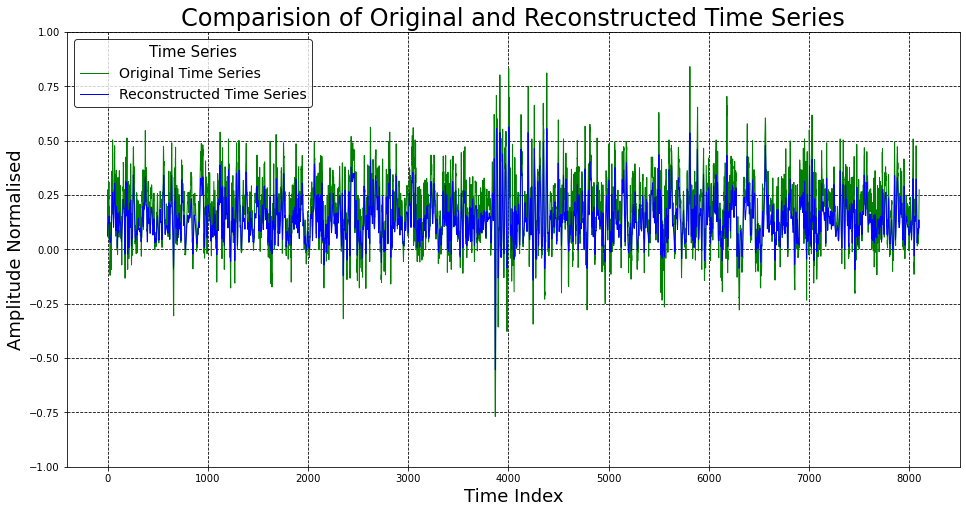

In [30]:
plt.figure(figsize=(16,8)) # Figure
plt.plot(testX[0], color='green', linewidth=1, label='Original Time Series') # Plot Original Time Series
plt.plot(y_pred[0], color='blue', linewidth=1, linestyle='-', label='Reconstructed Time Series') # Plot Reconstructed Time Series
plt.title('Comparision of Original and Reconstructed Time Series', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Index', fontdict={'fontsize':18}) # X-Label
plt.ylabel('Amplitude Normalised', fontdict={'fontsize':18}) # Y-Label
plt.grid(True, color='black', linestyle='--') # Grid
plt.ylim((-1,1)) # Y-Limit
plt.legend(fontsize=14, title='Time Series', edgecolor='black', title_fontsize=15) # Legend
plt.show() # Show

#### Plot Compressed Data

In [41]:
original_data = testX[10] # Original Data
original_data = np.expand_dims(original_data, axis=0) # Expand into 3-D array 
compressed_data = ENCODER.predict(original_data) # Encrypted Data
predict_data = AUTOENCODER.predict(original_data) # Predict and Reconstruct
print('Original Data Shape:', original_data.shape) # Print Shape
print('Compressed Data Shape:', compressed_data.shape) # Print Shape
print('Reconstructed Data Shape:', predict_data.shape) # Print Shape

Original Data Shape: (1, 8100, 1)
Compressed Data Shape: (1, 100, 1)
Reconstructed Data Shape: (1, 8100, 1)


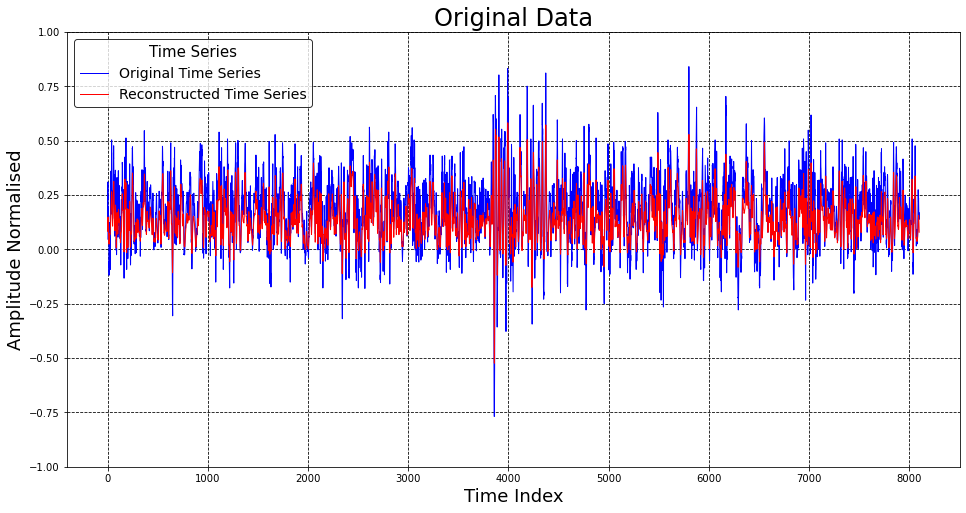

In [42]:
plt.figure(figsize=(16,8)) # Figure
plt.plot(original_data[0], color='blue', linewidth=1, label='Original Time Series') # Plot Original Time Series
plt.plot(predict_data[0], color='red', linewidth=1, label='Reconstructed Time Series') # Plot Reconstructed Time Series
plt.title('Original Data', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Index', fontdict={'fontsize':18}) # X-Label
plt.ylabel('Amplitude Normalised', fontdict={'fontsize':18}) # Y-Label
plt.grid(True, color='black', linestyle='--') # Grid
plt.ylim((-1,1)) # Y-Limit
plt.legend(fontsize=14, title='Time Series', edgecolor='black', title_fontsize=15) # Legend
plt.show() # Show

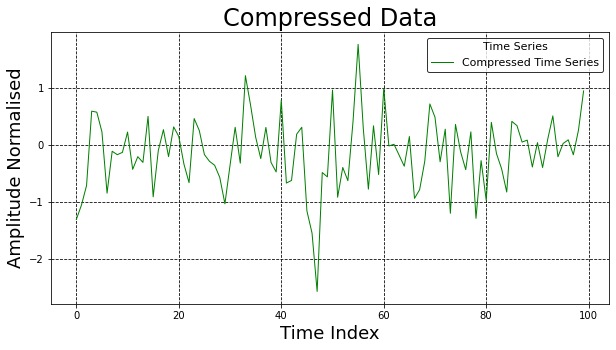

In [60]:
plt.figure(figsize=(10,5)) # Figure
plt.plot(compressed_data[0], color='green', linewidth=1, label='Compressed Time Series') # Plot Original Time Series
plt.title('Compressed Data', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Index', fontdict={'fontsize':18}) # X-Label
plt.ylabel('Amplitude Normalised', fontdict={'fontsize':18}) # Y-Label
plt.grid(True, color='black', linestyle='--') # Grid
plt.legend(fontsize=11, title='Time Series', edgecolor='black', title_fontsize=11) # Legend
plt.show() # Show

### Use ENCODER Model to extract Encrypted Data

In [70]:
directory = 'Gearbox Dataset/' # Directory Name
n_files = 560 # Number of files

#### Helper Function

In [71]:
def create_data_for_clustering(n_files, directory):
    '''Creates Data of 3-D for clustering.
       Pass: Number of Files and Directory Name.
       Return: Two 3-D Array'''
    data_1 = [] # Empty List for Series 1
    data_2 = [] # Empty List for Series 1
    
    for i in range(1, n_files+1): # Loop through the directories
        df = pd.read_csv(directory+f'Run_{str(i)}.csv', header=None) # Read CSV File
        series_1 = df[[0]] # Vibration Data 1
        series_2 = df[[1]] # Vibration Data 2

        # Extract Chunk of Data
        series_1 = series_1[8100:16200] # Extract Data of size 8100
        series_2 = series_2[8100:16200] # Extract Data of size 8100

        # Expand the Series 
        series_1 = np.expand_dims(series_1, axis=0) # Expand into 3-D array 
        series_2 = np.expand_dims(series_2, axis=0) # Expand into 3-D array

        # Compress Data
        series_1 = ENCODER.predict(series_1) # Encrypted Data
        series_2 = ENCODER.predict(series_2) # Encrypted Data

        # Create Final Data for clustering
        data_1.append(series_1[0]) # Append to List
        data_2.append(series_2[0]) # Append to List

    data_1 = np.array(data_1) # To array
    data_2 = np.array(data_2) # To array
    return data_1, data_2 # Return

#### Call

In [72]:
data_1, data_2 = create_data_for_clustering(n_files, directory) # Call Function

In [73]:
print('Shape of Data 1:', data_1.shape) # Print Shape
print('Shape of Data 2:', data_2.shape) # Print Shape

Shape of Data 1: (560, 100, 1)
Shape of Data 2: (560, 100, 1)


## Clustering

### Create Model and Fit

In [88]:
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=100)
y_pred = model.fit_predict(data_1)

In [132]:
model.inertia_

0.09163525194753083

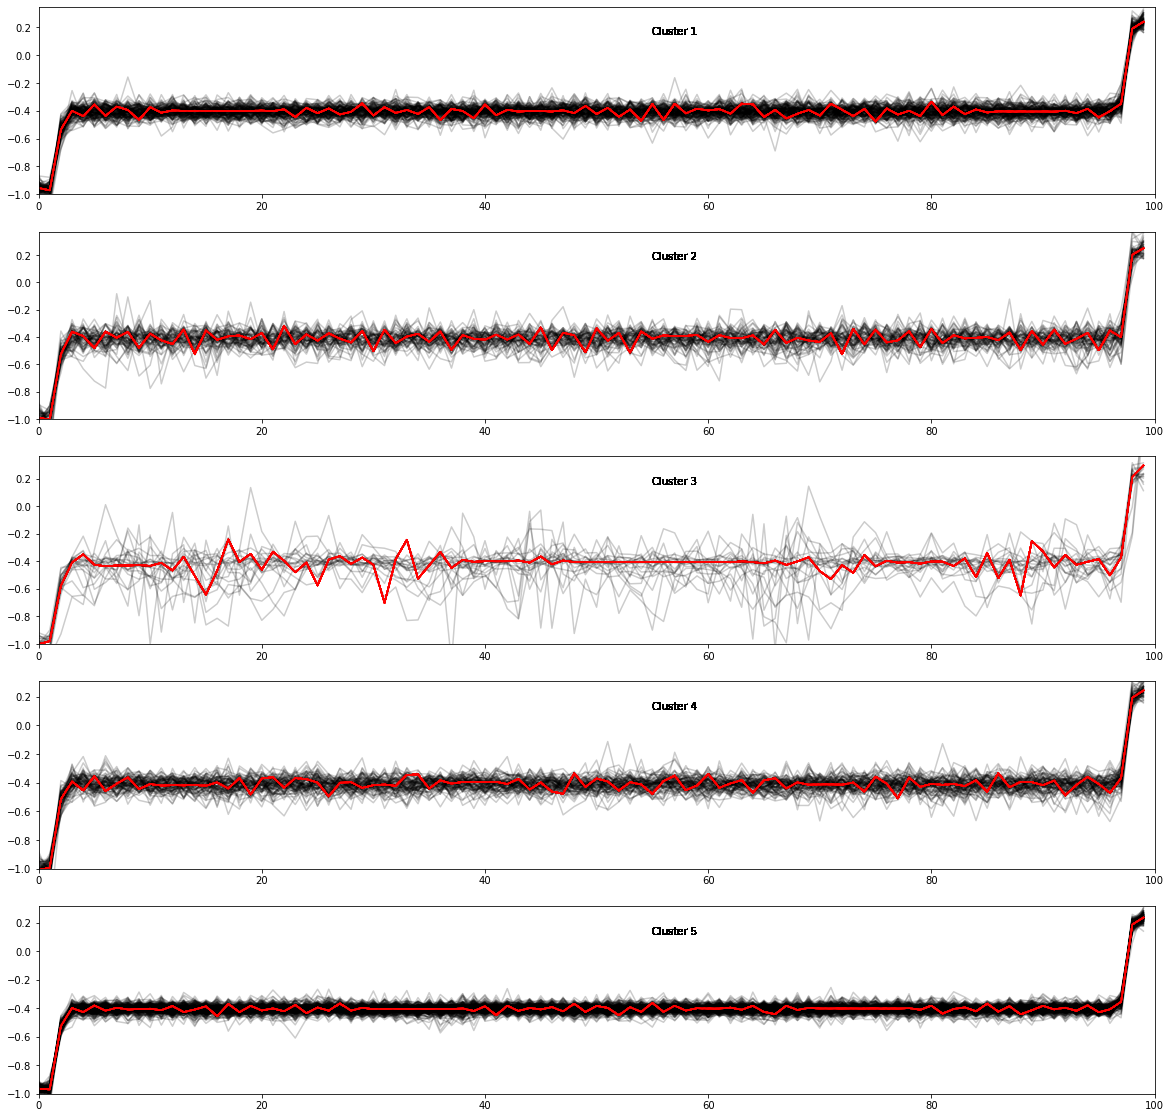

In [138]:
sz=data_1.shape[1]
plt.figure(figsize=(20,20))
for yi in range(5):
    plt.subplot(5, 1, 1+yi)
    for xx in data_1[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-1, )
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
        transform=plt.gca().transAxes)
plt.show()

#### Create a Dataframe containing which file belongs to which Cluster

In [120]:
df_clustered = pd.DataFrame(columns=['File', 'Cluster']) # Create Data Frame
li_files =[] # To get Names of File
li_cluster =[] # To get the cluster labels
for i in range(y_pred.shape[0]): # Loop
    li_files.append(f'Run_{str(i+1)}') # Append
    li_cluster.append(y_pred[i]+1) # Append

# Append to Data Frame
df_clustered['File'] = li_files
df_clustered['Cluster'] = li_cluster

#### Cluster 1

In [122]:
cluster_1 = df_clustered[df_clustered['Cluster']==1]
print('Shape of Cluster 1:', cluster_1.shape)
cluster_1.head()

Shape of Cluster 1: (136, 2)


,File,Cluster
0,Run_1,1
4,Run_5,1
5,Run_6,1
6,Run_7,1
8,Run_9,1


#### Cluster 2

In [123]:
cluster_2 = df_clustered[df_clustered['Cluster']==2]
print('Shape of Cluster 2:', cluster_2.shape)
cluster_2.head()

Shape of Cluster 2: (56, 2)


,File,Cluster
9,Run_10,2
10,Run_11,2
12,Run_13,2
28,Run_29,2
29,Run_30,2


#### Cluster 3

In [124]:
cluster_3 = df_clustered[df_clustered['Cluster']==3]
print('Shape of Cluster 3:', cluster_3.shape)
cluster_3.head()

Shape of Cluster 3: (20, 2)


,File,Cluster
2,Run_3,3
35,Run_36,3
103,Run_104,3
119,Run_120,3
135,Run_136,3


#### Cluster 4

In [125]:
cluster_4 = df_clustered[df_clustered['Cluster']==4]
print('Shape of Cluster 4:', cluster_4.shape)
cluster_4.head()

Shape of Cluster 4: (75, 2)


,File,Cluster
11,Run_12,4
24,Run_25,4
25,Run_26,4
41,Run_42,4
57,Run_58,4


#### Cluster 5

In [126]:
cluster_5 = df_clustered[df_clustered['Cluster']==5]
print('Shape of Cluster 5:', cluster_5.shape)
cluster_5.head()

Shape of Cluster 5: (273, 2)


,File,Cluster
1,Run_2,5
3,Run_4,5
7,Run_8,5
13,Run_14,5
14,Run_15,5


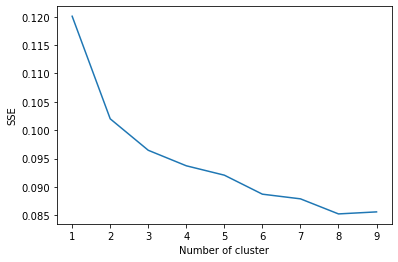

In [131]:
sse = {}
for k in range(1, 10):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100).fit(data_1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

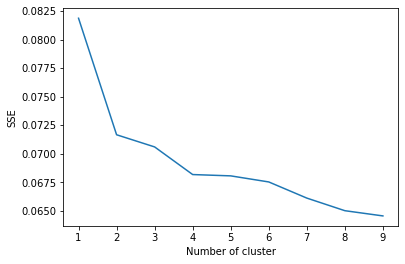

In [130]:
sse = {}
for k in range(1, 10):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100).fit(data_2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()